# Notebook 5: Dimensionality Reduction and Clustering

## Introduction

In this notebook we will explore Dimensionality Reduction and to a lesser extent Clustering. 

We will use the MNIST data set, a standard testbed for simple machine learning tasks, which is described in the wiki: https://en.wikipedia.org/wiki/MNIST_database. It comprises a training set of 60,000 handwritten images, and a test set of 10,000. Each data point consists of a 24x24 pixel image, which represents one of 10 handwritten numbers. It is often used for classification purposes, however we will apply different dimensionality and clustering methods to the data set.

Initially we will be applying dimensionality reduction for visualisation purposes, and we will begin by applying Principal Components Analysis (PCA): both using Scikit-Learn and a version coded by hand. Following this we will look at using Linear Discriminant Analysis as well as $t$-SNE.

Next we will examine different uses of dimensionality reduction, such as: Increasing the training speed of a logistic classifier; improving predictive performance on noisy images; and reconstructing de-noised images.

Finally we will introduce clustering to aid classification accuracy when we have only a few labelled training examples.

Dimensionality reduction and Clustering are both reasonably large areas within Machine Learning and we have merely scratched the surface of these fields of study. The goal of the laboratory is to come away with an understanding of some application areas and be able to implement the simpler ones yourselves.

Some of the code in this notebook originally comes from code accompanying 'Hands-On Machine Learning with Scikit-Learn & Tensorflow', by A. Geron.

## Imports

Please do not change the cell below, you will see a number of imports. All these packages are relevant for the assignment and it is important that you get used to them. You can find more information about them in their respective documentation. As usual Numpy, Pandas, and Scikit-Learn will be used heavily.

In [1]:
#Standard Python libraries for data and visualisation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.cluster  import KMeans

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist

from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()

import time
%matplotlib inline

## Load Data

We will begin by loading the MNIST data set, defining some useful helper functions, and plotting some sample training digits from the data set.

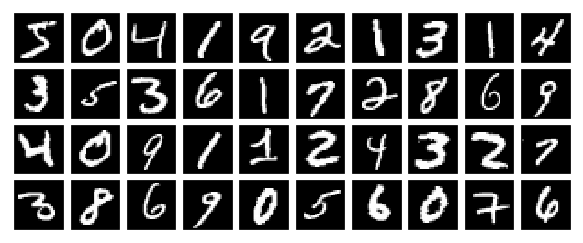

In [2]:
#PLEASE DO NOT CHANGE THIS CELL
#Import our train/ test data plus a few helper functions.
(X_train_orig, y_train_orig), (X_test_orig, y_test_orig) = mnist.load_data()
X_train, y_train, X_test, y_test = X_train_orig, y_train_orig, X_test_orig, y_test_orig

def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(28, 28),cmap = plt.cm.gray, interpolation='nearest',
                  clim=(0, 255))
                
def plot_2d(projected, y_train, title):
    fig = plt.figure(figsize=(8, 6), dpi=80)
    ax = fig.add_subplot(111)

    p = ax.scatter(projected[:, 0], projected[:, 1],
                c=y_train, edgecolor='none', alpha=0.5,
                  cmap='tab10')
    ax.set_xlabel('component 1')
    ax.set_ylabel('component 2')
    ax.set_title(title)
    fig.colorbar(p);
    
def print_results(y_pred, y_test):
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');

    print("Accuracy on test set: ", accuracy_score(y_test, y_pred))
    
    
plot_digits(X_train[:40])
num_examples = 7000

## Create training and test data

__Task:__  
Take the first 7000 training examples and use a scaler to scale the data.  
Each image is originally in a 24x24 numpy array, so please flatten the data, and be sure to fit the scaler on only the training data.  
Please keep the variable names the same, that is: `X_train`, `y_train`, `X_test`.

In [3]:
########################################################
# TO_DO
#[your code here]

X_train = X_train.reshape(-1,784)
X_train = X_train[:num_examples,:]
y_train = y_train[:num_examples]

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = X_test.reshape(-1,784)
X_test = scaler.transform(X_test)

# /TO_DO
########################################################

/home/dariush/anaconda3/envs/tf_env/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/dariush/anaconda3/envs/tf_env/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/dariush/anaconda3/envs/tf_env/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Dimensionality Reduction for Visualisation

### Principal Components Analysis:

We will now use Scikit-Learn to project the data to 2-dimensions.  
If you have set up the data correctly then the training data will have shape (7000, 784), the projected data will have shape (7000,2), and the explained variance will be around 10.6%.  
Be sure to understand the code!

In [4]:
#PLEASE DO NOT CHANGE THIS CELL
pca = PCA(n_components=2)
projected = pca.fit_transform(X_train)

print("Training data shape :", X_train.shape)
print("Projected data shape :", projected.shape)
print("Explained variance :", np.sum(pca.explained_variance_ratio_))

Training data shape : (7000, 784)
Projected data shape : (7000, 2)
Explained variance : 0.10652853336229881


### Visualising the Projected Data:

We now visualise the 7000 training images in 2-dimensions.  
Notice that similarly classified images tend to be somewhat clustered together (remember that PCA is an unsupervised technique and does not know the training target labels).  
Also note that there is considerable overlap in the clusters.

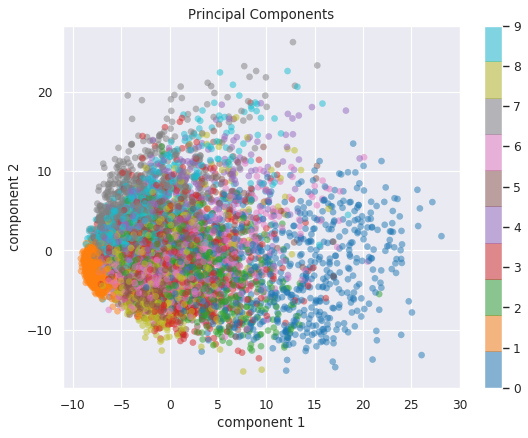

In [5]:
#PLEASE DO NOT CHANGE THIS CELL
plot_2d(projected, y_train[:num_examples], 'Principal Components')

### Visualising Explained Variance by the Number of Components:

The chart below shows the cumulative explained variance as we increase the number of components.  
With 784 components we can explain all of the variance (why?), meanwhile projecting into 2 dimensions only explains just over 10% of the variance.

__Question:__  
How would you go about deciding a good number of components to use in the trade-off between good explainability of the data and a lower dimensional representation?

Text(0.5, 1.0, 'Explained variance as components increase')

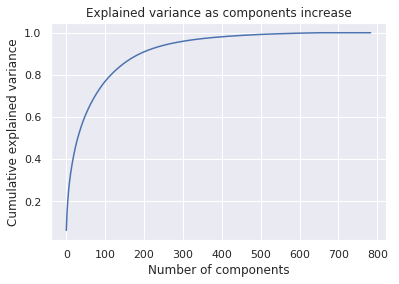

In [6]:
#PLEASE DO NOT CHANGE THIS CELL
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');
plt.title('Explained variance as components increase')

### PCA by Hand:

We are now going to try implementing PCA (and the chart above) by hand:

__Task:__  
1) Without using the `np.cov` function please create a covariance matrix of the training data, (call this `cov_mat`). The shape of this matrix should be 784x784 (why?)  
2) Using `np.linalg.eig` or otherwise, please find the eigenvalues and associated eigenvectors of the data. Store them in numpy arrays named `eig_vals`, `eig_vecs`. `eig_vals` should have shape (784,) and `eig_vecs` should have shape (784,784).  
3) Project the data onto 2-dimensions, using the 2 highest eigenvalues and associated eigenvectors, by creating a projection matrix called `matrix_w` (What shape should `matrix_w` be?)  
4) Please create a variable, `Y`, by applying the projection matrix to your training data (`Y` should have shape (7000,2)).

In [7]:
########################################################
# TO_DO
#[your code here]

#cov_mat = np.cov(X_train.T)
mean_vec = np.mean(X_train, axis=0)
cov_mat = (X_train - mean_vec).T.dot((X_train - mean_vec)) / (X_train.shape[0]-1)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)

matrix_w = np.hstack((eig_pairs[0][1].reshape(784,1), 
                      eig_pairs[1][1].reshape(784,1)))

#project the data
Y = X_train.dot(matrix_w)

# /TO_DO
########################################################

In [8]:
#PLEASE DO NOT CHANGE THIS CELL
exp_var = np.sum(eig_vals[:2])/np.sum(eig_vals)

print("X_train shape :", X_train.shape)
print("Covariance matrix shape :", cov_mat.shape)
print("Eigenvalues shape :", eig_vals.shape)
print("Eigenvectors shape :",eig_vecs.shape)
print("Projection matrix shape :",matrix_w.shape)
print("Projected data shape:",Y.shape)
print("Explained variance: ",exp_var)

X_train shape : (7000, 784)
Covariance matrix shape : (784, 784)
Eigenvalues shape : (784,)
Eigenvectors shape : (784, 784)
Projection matrix shape : (784, 2)
Projected data shape: (7000, 2)
Explained variance:  (0.10652853353132334+0j)


### Visualising the Projected Data Using Your Hand-Coded Version:

If you have coded the above correctly then the chart below should match the projection from Scikit-Learn.

/home/dariush/anaconda3/envs/tf_env/lib/python3.7/site-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


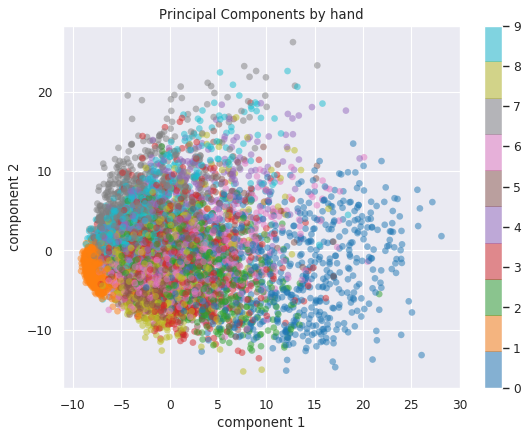

In [9]:
#PLEASE DO NOT CHANGE THIS CELL
plot_2d(-Y, y_train[:num_examples],'Principal Components by hand')

## Linear Discriminant Analysis

We will now apply a similar projection and visualisation with Linear Discriminant Analysis. 

__Task:__  
1) Research Linear Discriminant Analysis and understand key differences with the approach of PCA.  
2) Create a variable, `X_lda_sklearn`, which contains the 7000 training examples projected to 2-dimensions using `LDA` in Scikit-Learn.

In [10]:
########################################################
# TO_DO
#[your code here]

sklearn_lda = LDA(n_components=2)
X_lda_sklearn = sklearn_lda.fit_transform(X_train, y_train)

# /TO_DO
########################################################

/home/dariush/anaconda3/envs/tf_env/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


### Visualising the LDA Projected Data:

Again we show the visualisation of the projected data.  

This time you should see a far greater separation of the clusters compared to PCA.

__Question:__   
Why do you think this is the case?

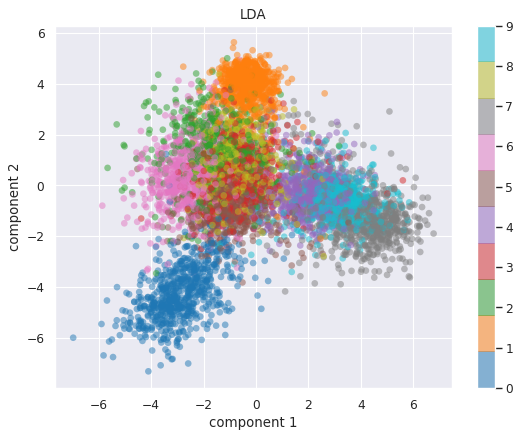

In [11]:
#PLEASE DO NOT CHANGE THIS CELL
plot_2d(X_lda_sklearn, y_train[:num_examples],'LDA')

## $t$-SNE

We will now apply $t$-SNE for our final visualisation. We return to applying dimensionality reduction but without knowing the training target labels.

__Task:__  
1) Look up $t$-SNE and understand at a high level what it attempts to do.   
2) To reduce the amount of computation, first reduce the training data to 50 dimensions using PCA.  
3) Fit the data using `TSNE`. Use the following paramaters, `n_components=2`, `verbose=1`, `perplexity=40`, `n_iter=300`, `random_state=42`.   
4) Store the dimensionality-reduced data in a variable called `X_reduced_tsne`. We will use this variable to plot the result.

In [12]:
########################################################
# TO_DO
#[your code here]

pca = PCA(n_components=50)
X_train_50d = pca.fit_transform(X_train)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=42)
X_reduced_tsne = tsne.fit_transform(X_train_50d)

# /TO_DO
########################################################

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7000 samples in 0.010s...
[t-SNE] Computed neighbors for 7000 samples in 4.016s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 4.210090
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.815559
[t-SNE] KL divergence after 300 iterations: 2.321311


### Visualising the $t$-SNE Projected Data:

You should see that $t$-SNE has projected the data, clustering images with the same label, but with a better separation between images with different labels (than for example PCA).  
Remember that $t$-SNE is not told the labels. 

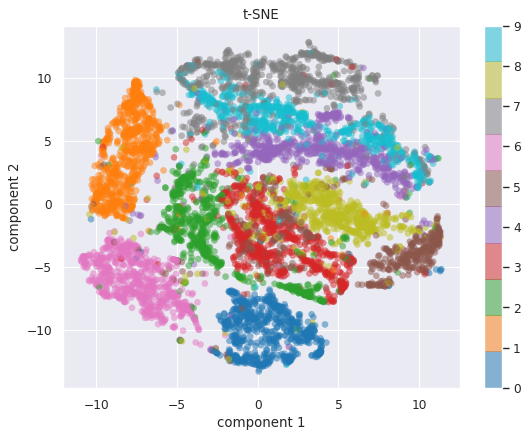

In [13]:
#PLEASE DO NOT CHANGE THIS CELL
plot_2d(X_reduced_tsne, y_train[:num_examples],'t-SNE')

## Dimensionality Reduction to Reduce Computational Load

We will now briefly examine dimensionality reduction to improve the training speed of a simple machine learning algorithm.  
We will be applying Logistic Regression to classify the MNIST data.

__Task:__  
1) Create a Logistic Regression object from Scikit-Learn. Remember that this is a multi-class regression. Set `solver="lbfgs"` (a choice of optimiser to speed things up), and set `random_state=42`.  
2) Fit your model to the training data and time how long it took to do so. Store this time in a variable called `training_time`.  
3) Apply your model to the test data, `X_test`, and create a set of predictions on the unseen test set. Store these predictions in a variable called `y_pred`.

In [14]:
########################################################
# TO_DO
#[your code here]

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()
training_time = t1-t0

y_pred = log_clf.predict(X_test)

# /TO_DO
########################################################

/home/dariush/anaconda3/envs/tf_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


### Baseline Logistic Regression Performance:
In the cell below the accuracy, training time, and a confusion matrix of the results are displayed.  
You should have an accuracy of close to 89%. If you did not get this result, then things to check inlcude: Did you use the 7000 training examples? Were both the training and test data standardised? Did you apply the correct model?  

Accuracy on test set:  0.8863
Training took 1.15s


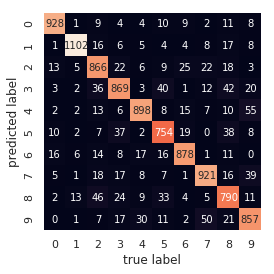

In [15]:
#PLEASE DO NOT CHANGE THIS CELL
print_results(y_pred, y_test)
print("Training took {:.2f}s".format(training_time))

### Pre-Process Using PCA:

__Task:__  
We will now do exactly the same thing: We will produce two variables `y_pred` and `training time`.  
However this time we would like you to apply a single preprocessing step:  
1) Pre-process the training data using principal components. Specifically, reduce the dimensionality of the training set such that 95% of the variance of the data remains explained (Note that there is a shortcut to do this using the `n_compoonents` parameter).  
2) Now repeat the earlier steps, but this time train your model on the reduced dimensionality training set.

In [16]:
########################################################
# TO_DO
#[your code here]

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf.fit(X_train_reduced, y_train)
t1 = time.time()
training_time = t1-t0

X_test_reduced = pca.transform(X_test)
y_pred = log_clf.predict(X_test_reduced)

# /TO_DO
########################################################

/home/dariush/anaconda3/envs/tf_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


### PCA Results:
In the cell below the accuracy, training time, and a confusion matrix of the results are displayed.  
You should find that we achieve almost exactly the same accuracy on the test set, but we halved the training time.

Accuracy on test set:  0.8858
Training took 0.55s


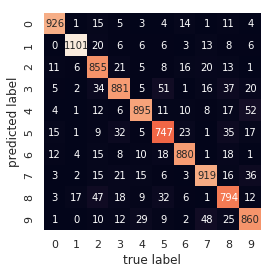

In [17]:
#PLEASE DO NOT CHANGE THIS CELL
print_results(y_pred, y_test)
print("Training took {:.2f}s".format(training_time))

## Dimensionality Reduction Applied to Noisy Data

We will now apply dimensionality reduction (again PCA) to the problem of noisy data.  
In the cell below we have reloaded our training data, but this time have added noise. The visualisation of some of the now noisy training data images is given below.

Our variables are now `noisy_train`, `noisy_test`, with `y_train` and `y_test` remaining the same.

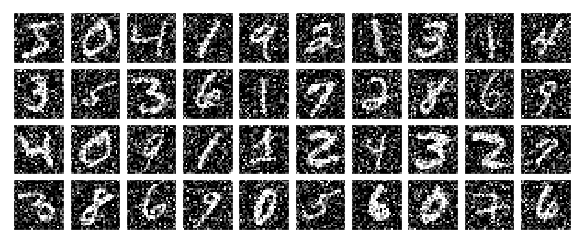

In [18]:
#PLEASE DO NOT CHANGE THIS CELL
X_train, y_train, X_test, y_test = X_train_orig, y_train_orig, X_test_orig, y_test_orig
X_train = X_train[:num_examples,:]
y_train = y_train[:num_examples]

np.random.seed(42)
noisy_train = np.random.normal(X_train, 100)
noisy_test = np.random.normal(X_test, 100)
plot_digits(noisy_train[:40])

### Baseline Logistic Regression Performance - Noisy Data:

__Task:__  
1) Fit a Logistic Regression model to the `noisy_train data`.  
2) Create a set of predictions, again stored in `y_pred` on the test set, `noisy_test`.  
(Please check the dimensions of the inputs and reshape if necessary).

In [19]:
########################################################
# TO_DO
#[your code here]

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)

noisy_train = noisy_train.reshape(-1,784)
noisy_test = noisy_test.reshape(-1,784)
log_clf.fit(noisy_train, y_train)

y_pred = log_clf.predict(noisy_test)

# /TO_DO
########################################################

/home/dariush/anaconda3/envs/tf_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


### Baseline Results - Noisy Data:
We have given the accuracy on the test set as well as the confusion matrix.   
You should see that the prediction accuracy has deteriorated.

Accuracy on test set:  0.786


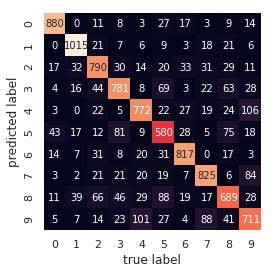

In [20]:
#PLEASE DO NOT CHANGE THIS CELL
print_results(y_pred, y_test)

### Pre-Process Using PCA - Noisy data:

__Task:__   
Please perform the same exercise but this time apply principal components to the training data as a pre-processing step and train the model on the reduced dimensionality data.  
Set `n_components = 0.25`.   
Store the predictions on the test set in `y_pred`.

In [21]:
########################################################
# TO_DO
#[your code here]

pca = PCA(n_components=0.25)
X_train_reduced = pca.fit_transform(noisy_train)

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
log_clf.fit(X_train_reduced, y_train)

X_test_reduced = pca.transform(noisy_test)
y_pred = log_clf.predict(X_test_reduced)

# /TO_DO
########################################################

/home/dariush/anaconda3/envs/tf_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


### PCA Results - Noisy Data:

Again we have given the accuracy on the test set as well as the confusion matrix.   

__Questions:__  
1) Why do you think the performance is improved by preprocessing using PCA in this particular example?  
2) Do you think this is usually the case, or that indeed performance could have actually deteriorated in some cases?  
3) How would you go about deciding whether this might be sensible for your particular training set?

Accuracy on test set:  0.8524


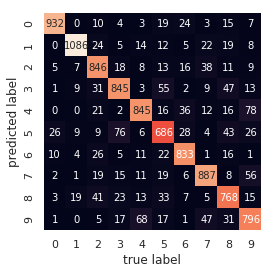

In [22]:
#PLEASE DO NOT CHANGE THIS CELL
print_results(y_pred, y_test)

## Denoising Via Reconstruction Using PCA 

Here we will very briefly show an application of PCA:  
We will use your trained PCA model to reconstruct de-noised images.  
In the cell below we plot the first 40 test images.

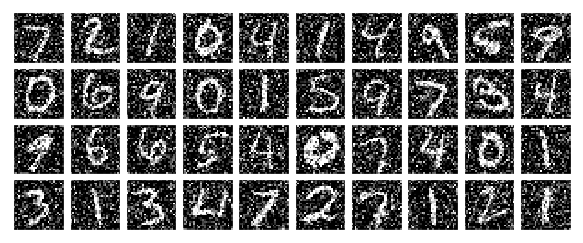

In [23]:
#PLEASE DO NOT CHANGE THIS CELL
plot_digits(noisy_test[:40])

__Task:__  
Please use the PCA model you created and fitted above.  
1) If you called your PCA model say `pca`, than apply `pca.transform` to the test data.  
2) Apply `pca.inverse_transform` to this result and store in a variable called `filtered`.

In [24]:
########################################################
# TO_DO
#[your code here]

filtered = pca.inverse_transform(pca.transform(noisy_test))

# /TO_DO
########################################################

### PCA Denoising - Results:

If all has been implemented correctly then in the cell below you should see the same test images, but this time with much of the noise removed.  
Remember that the model was fitted to only the training data and had not seen these test images.

__Question:__  
Why do you think the de-noised images are blurry?

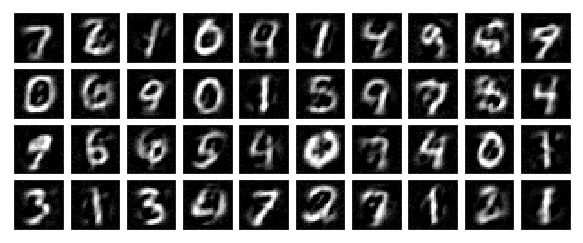

In [25]:
#PLEASE DO NOT CHANGE THIS CELL
plot_digits(filtered[:40])

## Denoising Autoencoder
The code below comes from the excellent Keras blog https://blog.keras.io/. 

We have applied the code to the images which we have been working with in this laboratory.

The code takes a little time to run, but will create noisy training images, train a de-noising convolutional autoencoder on the training images, and then display a few noisy test images as well as their denoised versions.

This is simply for demonstration purposes to show that there are more powerful denoising models. 

__Question:__  
Auto-encoders have some relationships to PCA, but are more general for a particular reason. What is this reason?

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 37s 608us/step - loss: 0.1744 - val_loss: 0.1217
Epoch 2/5
60000/60000 [==============================] - 37s 623us/step - loss: 0.1185 - val_loss: 0.1107
Epoch 3/5
60000/60000 [==============================] - 34s 573us/step - loss: 0.1112 - val_loss: 0.1067
Epoch 4/5
60000/60000 [==============================] - 36s 608us/step - loss: 0.1074 - val_loss: 0.1037
Epoch 5/5
60000/60000 [==============================] - 54s 900us/step - loss: 0.1054 - val_loss: 0.1050


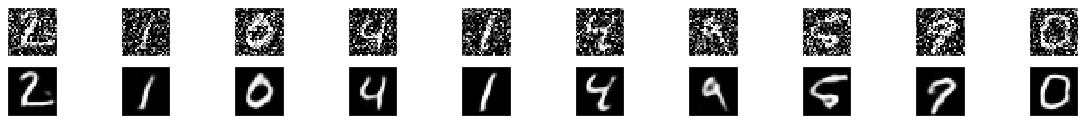

In [26]:
#PLEASE DO NOT CHANGE THIS CELL
#make autoencoder
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

#create noisy data
x_train, y_train, x_test, y_test = X_train_orig, y_train_orig, X_test_orig, y_test_orig

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

#Train autoencoder
autoencoder.fit(x_train_noisy, x_train,
                epochs=5,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

#predict on noisy test set
decoded_imgs = autoencoder.predict(x_test_noisy)

#plot the results
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,2*n+1):
    ax = plt.subplot(2, 10, i)
    
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    if i>10:
        plt.imshow(decoded_imgs[i-10].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

## Semi-Supervised Learning Via Clustering

We will now introduce the problem of classification of the data when we have very few labelled examples.  

It can often be the case that the good labelled examples are difficult to gather, due to time or cost or both.

In this case the problem setting is one where we only have the resources to label 100 of the 60,000 training examples. However we still need to predict on the entire 10,000 test set.

The cell below shows the first 40 training digits.   
(We have introduced a variable called `n_labelled` and set this equal to 100).

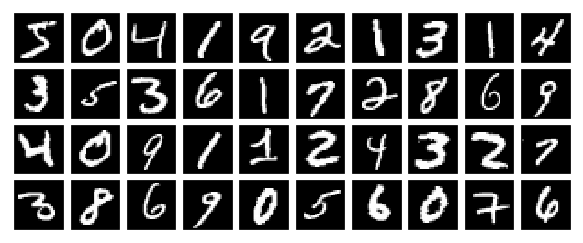

In [27]:
#PLEASE DO NOT CHANGE THIS CELL
X_train, y_train, X_test, y_test = X_train_orig, y_train_orig, X_test_orig, y_test_orig
X_train = X_train.reshape(-1,784)
X_test = X_test.reshape(-1,784)
n_labeled = 100

plot_digits(X_train[:40])

__Task:__  
Fit a Logistic Regression model on the first 100 training examples.  
Create the usual variable `y_pred` containing your model predictions on the test set, `X_test`.

In [28]:
########################################################
# TO_DO
#[your code here]

log_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

y_pred = log_reg.predict(X_test.reshape(-1,784))

# /TO_DO
########################################################

### Results - 100 Labelled Examples:
In the cell below the accuracy and a confusion matrix of the results are displayed.
You should find that the results are quite poor.

Accuracy on test set:  0.6775


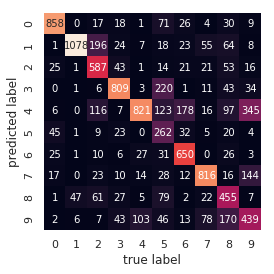

In [29]:
#PLEASE DO NOT CHANGE THIS CELL
print_results(y_pred, y_test)

### $k$-Means - Representative Labels:

Not all training examples are necessarily equal. If we only have the resources to label 100 training examples then perhaps we should be careful about the ones we choose.

We will use an unsupervised learning method, $k$-means, to cluster our training data into 100 clusters. Every training digit will thus have 10 different distances to the centroids of these clusters.

For each cluster across all training images we will choose the image that is closest to the centroid of that cluster, we call these representative digits. These 100 digits are then labelled.

In [30]:
#PLEASE DO NOT CHANGE THIS CELL
k = 100

kmeans  =  KMeans(n_clusters=k, random_state=42)

X_digits_dist = kmeans.fit_transform(X_train)
rep_digit_idx = np.argmin(X_digits_dist, axis=0)
X_rep_digits = X_train[rep_digit_idx]
y_rep_digits = y_train[rep_digit_idx]

### Representative Training Digits:

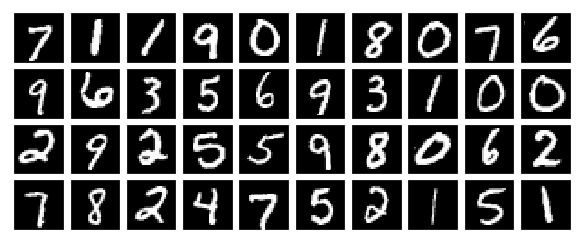

In [31]:
#PLEASE DO NOT CHANGE THIS CELL
plot_digits(X_rep_digits[:40])

__Task:__  
The new training data is stored in two variables: `X_rep_digits` and `y_rep_digits`.   
Fit a Logistic Regression model to this data and test on `X_test`. Store the results in `y_pred`.

In [32]:
########################################################
# TO_DO
#[your code here]

log_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
log_reg.fit(X_rep_digits, y_rep_digits)
y_pred = log_reg.predict(X_test.reshape(-1,784))

# /TO_DO
########################################################

### Representative Training Digits - Results:
We have given the accuracy on the test set as well as the confusion matrix.   
We are still only using 100 training examples, but you should see the accuracy on the test set increase significantly.

__Question:__   
This technique worked in this particular case, but can you think of cases where this will not be of benefit or may even be detrimental?

Accuracy on test set:  0.8205


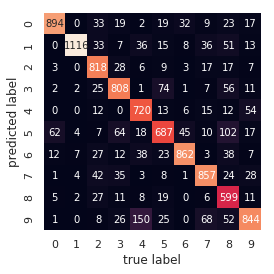

In [33]:
#PLEASE DO NOT CHANGE THIS CELL
print_results(y_pred, y_test)

### Propagating Cluster Labels:
(The code from the cell below comes from Geron's Dimensionality Reduction and Clustering work).

We have just used a small number of labelled digits and then labelled our clusters according to their distance from the representative labels given by these labelled digits. Thus we are hoping that the representative labels are good labels and that $k$-means provides a good clustering of that label.

Now if we throw out the furthest 5% (i.e. the least representative labels) then we gain another 5% increase in accuracy on the test set.

Thus, with only labelled 100 training examples, using $k$-means clustering to generate representative images which are then used to propagate labels, we are able to increase our test accuracy to over 87%

/home/dariush/anaconda3/envs/tf_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy on test set:  0.8735


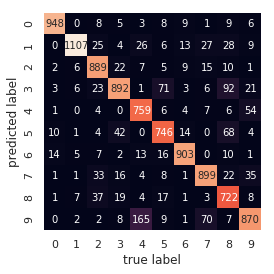

In [34]:
#PLEASE DO NOT CHANGE THIS CELL - for understanding only
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_rep_digits[i]

percentile_closest = 95

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

log_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

y_pred = log_reg.predict(X_test.reshape(-1,784))
print_results(y_pred, y_test)